# Spotting best trading entries and exits for daily trading of EVMOS 

EVMOS is one of the tokens on Cosmos ecosystem that had generous staking awards since its inception. Staking rewards are awarded at the end of the epoch, which happens to be at the same time every day, at around 9pm CET. Many stakers collect their rewards and immediately sell them causing a drop in price that during bull market tends to recover by the end of next day. 

With the following project I attempted to find the time of the day with the highest and the lowest prices in order to find the best entries and exits for the trade. The prices have orginally been acquired through an API but as it is a moving data I replaced it here with csv file. 

In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# https://api-osmosis.imperator.co/swagger/

In [71]:
def osmosis_api(token, minutes):
    api_url = "https://api-osmosis.imperator.co/tokens/v2/historical/"+token+"/chart?tf="+str(minutes)
    response = requests.get(api_url)
    data = response.json()
    ohlc = pd.DataFrame(data) 
    ohlc['datetime']= ohlc['time'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y %H:%M'))
    ohlc['datetime']=pd.to_datetime(ohlc['datetime'],format='%d-%m-%Y %H:%M')
    ohlc.set_index('datetime', inplace= True)
    price = pd.DataFrame(ohlc['close'])
    price.columns = [token]
    return price   

In [3]:
# https://api-osmosis.imperator.co/tokens/v2/historical/evmos/chart?tf=60


In [72]:
price= osmosis_api("EVMOS",60)
price.to_csv('evmos_price_real.csv')


In [95]:
price=pd.read_csv('evmos_price_real.csv', usecols=['datetime','EVMOS'], parse_dates=['datetime'])
# price = pd.read_csv("evmos_price.csv", parse_dates=['datetime'])


In [96]:
price = price.set_index('datetime')
price.head(10)


,EVMOS
datetime,
2023-05-13 21:00:00,0.153738
2023-05-13 22:00:00,0.147265
2023-05-13 23:00:00,0.142850
2023-05-14 00:00:00,0.142147
2023-05-14 01:00:00,0.140411
2023-05-14 02:00:00,0.142631
2023-05-14 03:00:00,0.147385
2023-05-14 04:00:00,0.146173
2023-05-14 05:00:00,0.145863


In [97]:
price['date']=price.index.date
price['time']=price.index.time

In [98]:
daily_mean = price.EVMOS.groupby(price['date']).mean()
daily_mean.columns=['date','mean']
daily_mean

date
2023-05-13    0.147951
2023-05-14    0.143348
2023-05-15    0.145935
2023-05-16    0.160455
2023-05-17    0.171578
2023-05-18    0.174024
2023-05-19    0.186686
2023-05-20    0.189350
2023-05-21    0.201659
2023-05-22    0.200698
2023-05-23    0.197442
Name: EVMOS, dtype: float64

In [99]:
mean=price.groupby('date')['EVMOS'].mean()

In [100]:
evmos_dev= pd.merge(left=price, right=mean, left_on='date', right_on='date', how='left',suffixes=('_price','_mean'))

In [101]:
evmos_dev['dev_from_mean']=evmos_dev['EVMOS_price']-evmos_dev['EVMOS_mean']
evmos_dev['dev_from_mean'].describe()

count    2.400000e+02
mean    -2.312965e-18
std      5.571767e-03
min     -1.606977e-02
25%     -4.036091e-03
50%      4.166842e-04
75%      3.869034e-03
max      1.397815e-02
Name: dev_from_mean, dtype: float64

In [102]:
evmos_dev.tail(5)

,EVMOS_price,date,time,EVMOS_mean,dev_from_mean
235,0.199081,2023-05-23,16:00:00,0.197442,0.001640
236,0.201163,2023-05-23,17:00:00,0.197442,0.003722
237,0.203381,2023-05-23,18:00:00,0.197442,0.005939
238,0.203174,2023-05-23,19:00:00,0.197442,0.005733
239,0.204389,2023-05-23,20:00:00,0.197442,0.006947


In [103]:
evmos_dev.reset_index().set_index(['date','time'])

index  EVMOS_price  EVMOS_mean  dev_from_mean
date       time                                                   
2023-05-13 21:00:00      0     0.153738    0.147951       0.005787
           22:00:00      1     0.147265    0.147951      -0.000687
           23:00:00      2     0.142850    0.147951      -0.005101
2023-05-14 00:00:00      3     0.142147    0.143348      -0.001202
           01:00:00      4     0.140411    0.143348      -0.002937
...                    ...          ...         ...            ...
2023-05-23 16:00:00    235     0.199081    0.197442       0.001640
           17:00:00    236     0.201163    0.197442       0.003722
           18:00:00    237     0.203381    0.197442       0.005939
           19:00:00    238     0.203174    0.197442       0.005733
           20:00:00    239     0.204389    0.197442       0.006947

[240 rows x 4 columns]

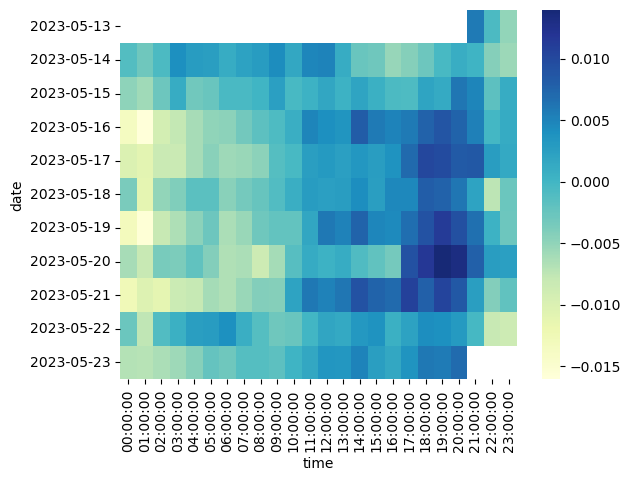

In [104]:
evmos_dev_pp = pd.pivot_table(evmos_dev, values='dev_from_mean', index=['date'],
                    columns=['time'])
sns.heatmap(data=evmos_dev_pp,center=0,cmap="YlGnBu")
plt.show()

In [158]:
evmos_dev.tail(5)

,EVMOS_price,date,time,EVMOS_mean,dev_from_mean
235,0.199081,2023-05-23,16:00:00,0.197442,0.001640
236,0.201163,2023-05-23,17:00:00,0.197442,0.003722
237,0.203381,2023-05-23,18:00:00,0.197442,0.005939
238,0.203174,2023-05-23,19:00:00,0.197442,0.005733
239,0.204389,2023-05-23,20:00:00,0.197442,0.006947


In [106]:
#Calculating average deviations from the mean every hour in the past 10 days.
time_dev = evmos_dev.groupby('time').dev_from_mean.mean()

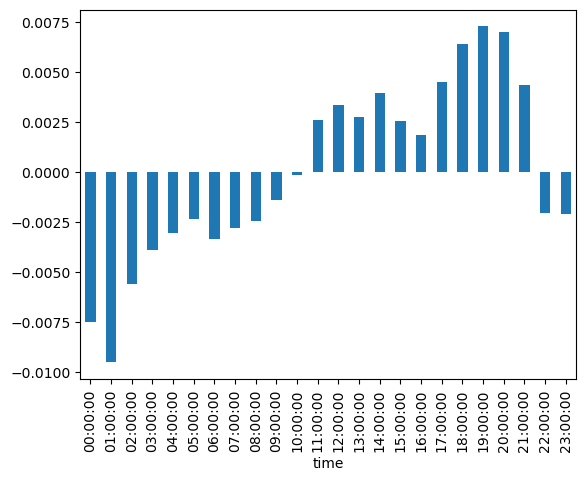

In [107]:
time_dev.plot(kind='bar')
plt.show()

In [133]:
max_hour = time_dev.idxmax().hour
print(max_hour)

19


In [119]:
min_hour = time_dev.idxmin().hour
print(min_hour)

1


In [124]:

price

,EVMOS,date,time,weekday
datetime,,,,
2023-05-13 21:00:00,0.153738,2023-05-13,21:00:00,5
2023-05-13 22:00:00,0.147265,2023-05-13,22:00:00,5
2023-05-13 23:00:00,0.142850,2023-05-13,23:00:00,5
2023-05-14 00:00:00,0.142147,2023-05-14,00:00:00,6
2023-05-14 01:00:00,0.140411,2023-05-14,01:00:00,6
...,...,...,...,...
2023-05-23 16:00:00,0.199081,2023-05-23,16:00:00,1
2023-05-23 17:00:00,0.201163,2023-05-23,17:00:00,1
2023-05-23 18:00:00,0.203381,2023-05-23,18:00:00,1


In [143]:
buytime = min_hour
selltime =max_hour
buysell= price[(price.index.hour == buytime )| (price.index.hour== selltime)].copy()
buysell

,EVMOS,date,time,weekday
datetime,,,,
2023-05-14 01:00:00,0.140411,2023-05-14,01:00:00,6
2023-05-14 19:00:00,0.142968,2023-05-14,19:00:00,6
2023-05-15 01:00:00,0.140132,2023-05-15,01:00:00,0
2023-05-15 19:00:00,0.147325,2023-05-15,19:00:00,0
2023-05-16 01:00:00,0.144385,2023-05-16,01:00:00,1
2023-05-16 19:00:00,0.169180,2023-05-16,19:00:00,1
2023-05-17 01:00:00,0.160581,2023-05-17,01:00:00,2
2023-05-17 19:00:00,0.181332,2023-05-17,19:00:00,2
2023-05-18 01:00:00,0.162969,2023-05-18,01:00:00,3


In [144]:
# Create a dictionary that maps integers to strings
mapping = {buytime:'buy', selltime:'sell'}

# Convert the 'bad_conditions' integers to strings using the 'mapping'
buysell['signal'] = buysell.index.hour.map(mapping)

In [145]:
buysell['return (%)']= (buysell.EVMOS.pct_change()* 100).round(2)
buysell.dropna()
buysell.sort_values(by='date')

,EVMOS,date,time,weekday,signal,return (%)
datetime,,,,,,
2023-05-14 01:00:00,0.140411,2023-05-14,01:00:00,6,buy,NaN
2023-05-14 19:00:00,0.142968,2023-05-14,19:00:00,6,sell,1.82
2023-05-15 01:00:00,0.140132,2023-05-15,01:00:00,0,buy,-1.98
2023-05-15 19:00:00,0.147325,2023-05-15,19:00:00,0,sell,5.13
2023-05-16 01:00:00,0.144385,2023-05-16,01:00:00,1,buy,-2.00
2023-05-16 19:00:00,0.169180,2023-05-16,19:00:00,1,sell,17.17
2023-05-17 01:00:00,0.160581,2023-05-17,01:00:00,2,buy,-5.08
2023-05-17 19:00:00,0.181332,2023-05-17,19:00:00,2,sell,12.92
2023-05-18 19:00:00,0.181744,2023-05-18,19:00:00,3,sell,11.52


In [154]:
sell = buysell[buysell['signal']=='sell']
avg_return = sell["return (%)"].mean().round(2)

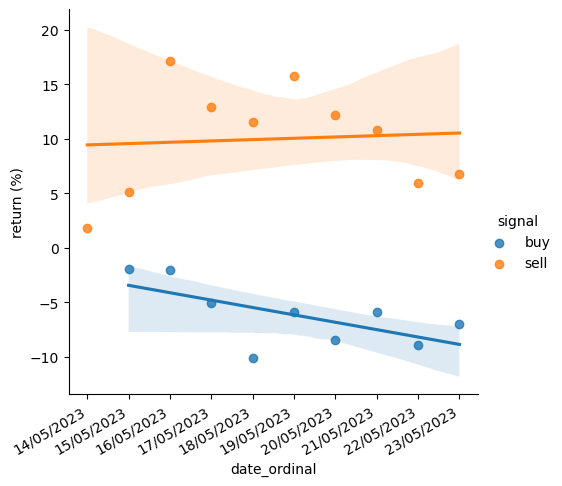

In [148]:
import matplotlib.dates as mdates
buysell['date'] = pd.to_datetime(buysell['date'])
buysell['date_ordinal'] = buysell['date'].apply(lambda date: mdates.date2num(date.to_pydatetime()))

sns.lmplot(data=buysell, y= 'return (%)', x='date_ordinal', hue='signal')

# Format x axis to display dates instead of numbers
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()


In [157]:
print(f"You can make on average {avg_return}% a day by buying EVMOS at {buytime}:00 and selling at {selltime}:00 every day!")

You can make on average 10.0% a day by buying EVMOS at 1:00 and selling at 19:00 every day!
